## Loan Repayment Predict 貸款償還預測
- 來自LendingClub.com的公開數據。
- 作為投資者，你會想投資那些表現出高概率償還你的人。
- 分類並預測借款人是否全額償還貸款。

### 預測
- 是否全額償還貸款 (not fully paid)

### 特徵定義
- credit.policy
    - 如果客戶符合LendingClub.com的信用承保標準則為 1 ，否則為 0。
- purpose
    - 貸款的目的（取值“信用卡式”，“債務重組”，“教育”，“重大收購”，“小生意”，和“所有其他”）。
- int.rate
    - 貸款的利率為期（11％寫作為0.11）。風險較高的借款人將獲得更高的利率
- installment
    - 如果貸款已獲得資金，則借款人所欠的每月分期付款。.
- log.annual.inc
    - 自我報告的借款人年收入的記錄.
- dti
    - 借款人的債務與收入比率（債務金額除以年收入）。
- fico
    - 借款人的FICO信用評分.
- days.with.cr.line
    - 借款人擁有信用額度的天數。
- revol.bal
    - 借款人的週轉金餘額（信用卡結算週期結束時未付的金額）.
- revol.util
    - 借款人的週轉線利用率（相對於可用總額使用的信用額度的數量）。
- inq.last.6mths
    - 借款人在過去6個月內債權人查詢的次數。
- delinq.2yrs
    - 借款人在過去2年中逾期30天以上的還款次數。
- pub.rec
    - 借款人的貶損性公共記錄（破產申請、稅收留置權或判決）的數量。
- not.fully.paid
    - 沒有全額償還貸款 

In [30]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# # 數值顯示至小數點後第二位
pd.set_option('display.precision', 2)

In [31]:
# 載入資料集
dataset = pd.read_csv('./data/Loan Repayment Predict/Loan_Repayment_Predict.csv')
dataset.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.1,11.35040654,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.08214255,14.29,707,2760.0,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.37349118,11.63,682,4710.0,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.35040654,8.1,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.29973224,14.97,667,4066.0,4740,39.5,0,1,0,0


#### 觀察資料

In [32]:
# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


#### 缺失值 Missing Value 檢查

Text(0.5, 1.0, 'Total Missing Value (%) in Dataset')

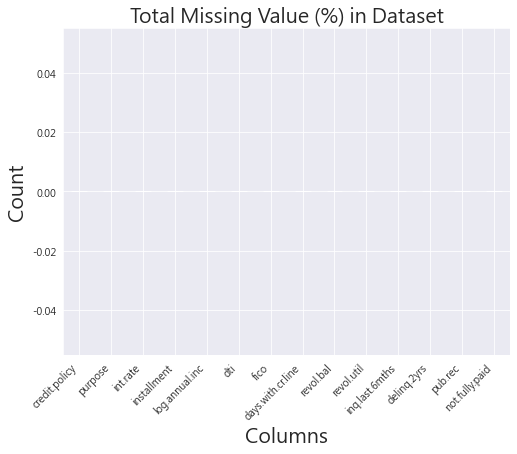

In [33]:
# 檢查缺失值
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# histogram
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Dataset", fontsize = 20)

#### 異常值檢查與處理 outlier
> - 先用 displot 與 catplot 觀察資料分布
> - 無明顯異常值，boxplot上的異常值均屬正常範圍
> - revol.bal :週轉金餘額有三筆資料過大，貸款內容為小生意，有可能金額較大

In [43]:
dataset.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0
mean,0.8049697222802256,0.12264006055543955,319.08941323867197,10.93211713780027,12.60667884735853,710.8463144706619,4560.767196529213,16913.963875548132,46.79923574859052,1.5774692002505741,0.1637084986427229,0.06212152850281896,0.16005429108373356
std,0.39624469870642526,0.026846987213382245,207.07130149985824,0.6148127513545925,6.883969540539616,37.97053722671365,2496.930376811348,33756.18955725052,29.014416965641065,2.2002453149372023,0.5462149246211591,0.26212632637427247,0.3666755411343701
min,0.0,0.06,15.67,7.547501683,0.0,612.0,178.9583333,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.1039,163.77,10.55841352,7.2124999999999995,682.0,2820.0,3187.0,22.6,0.0,0.0,0.0,0.0
50%,1.0,0.1221,268.95,10.92888357,12.665,707.0,4139.958333,8596.0,46.3,1.0,0.0,0.0,0.0
75%,1.0,0.1407,432.76249999999993,11.291292917500002,17.95,737.0,5730.0,18249.5,70.9,2.0,0.0,0.0,0.0
max,1.0,0.2164,940.14,14.52835448,29.96,827.0,17639.95833,1207359.0,119.0,33.0,13.0,5.0,1.0


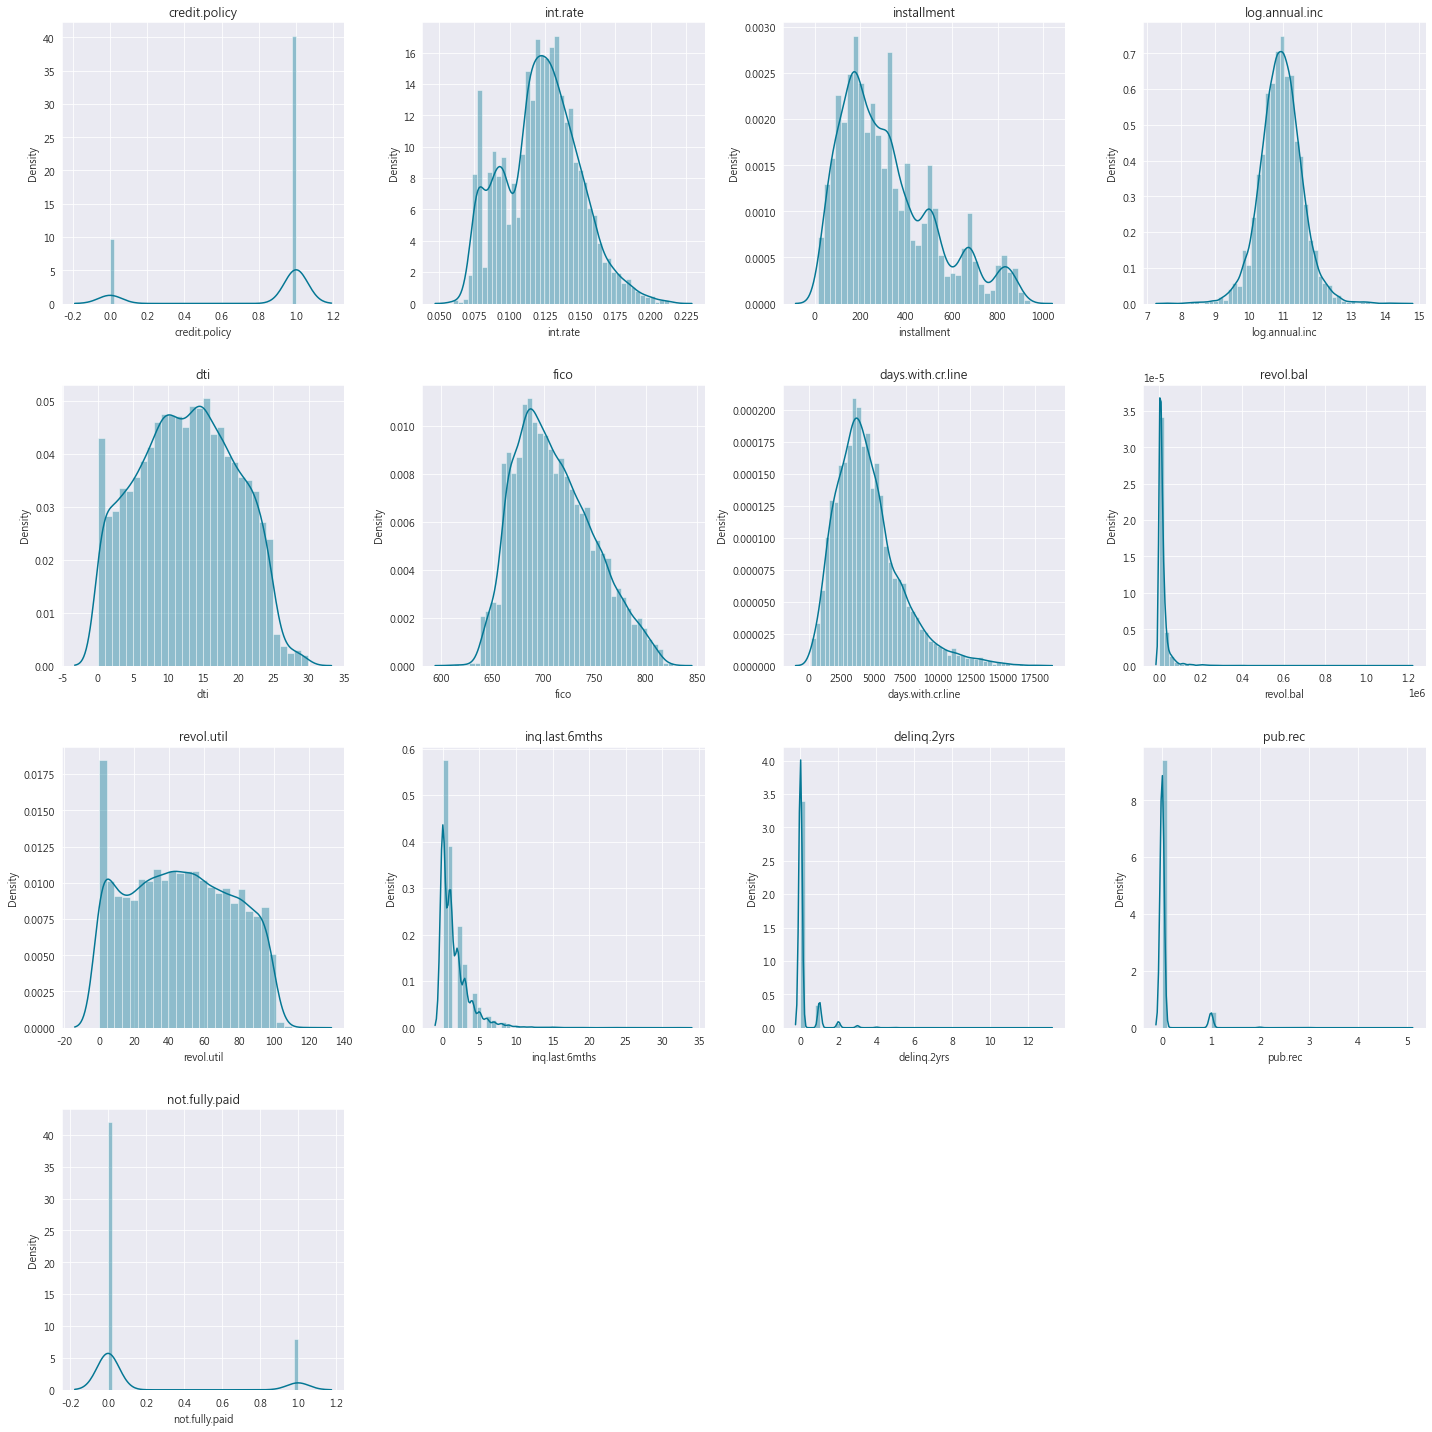

In [36]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

# 觀察所有人的核密度直方圖 查看分布
plt.figure(figsize=(20,20))
for i, source in enumerate(feature_numerical):
    # 指定好子圖的位置 
    plt.subplot(4, 4, i+1)
    # distplot
    sns.distplot(dataset[source], color = '#047794').set(xlabel=None)
    plt.title(source)
    
    plt.tight_layout(h_pad=3)
plt.show()

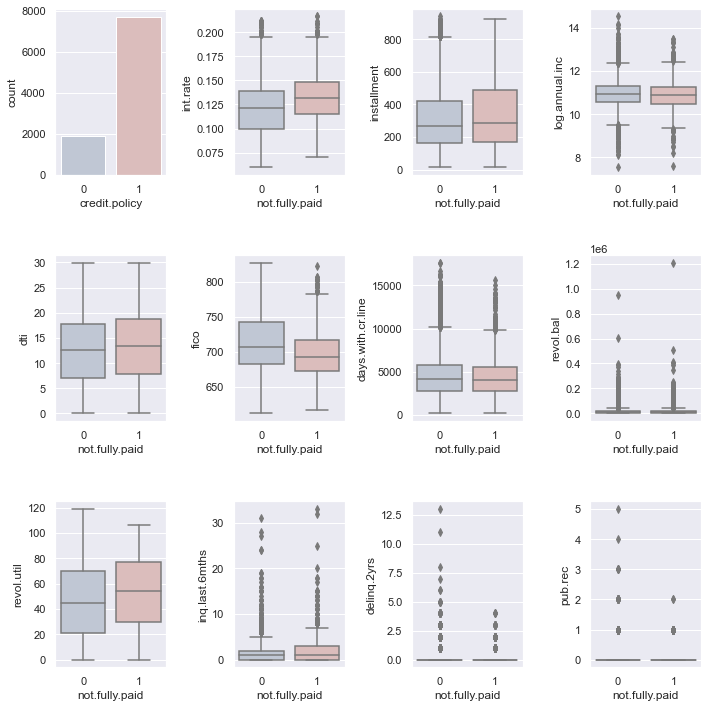

In [47]:
fig, axes = plt.subplots(3,4)
sns.set(rc={'figure.figsize':(10, 10)})
sns.countplot(x = "credit.policy", data=dataset, ax = axes[0,0], palette="vlag")
sns.boxplot(x = "not.fully.paid", y = "int.rate", data = dataset, ax = axes[0,1], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "installment", data = dataset, ax = axes[0,2], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "log.annual.inc", data = dataset, ax = axes[0,3], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "dti", data = dataset, ax = axes[1,0], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "fico", data = dataset, ax = axes[1,1], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "days.with.cr.line", data = dataset, ax = axes[1,2], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "revol.bal", data = dataset, ax = axes[1,3], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "revol.util", data = dataset, ax = axes[2,0], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "inq.last.6mths", data = dataset, ax = axes[2,1], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "delinq.2yrs", data = dataset, ax = axes[2,2], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "pub.rec", data = dataset, ax = axes[2,3], palette='vlag')
plt.tight_layout(h_pad=3)

In [37]:
# 觀察資料分布
dataset.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0
mean,0.8049697222802256,0.12264006055543955,319.08941323867197,10.93211713780027,12.60667884735853,710.8463144706619,4560.767196529213,16913.963875548132,46.79923574859052,1.5774692002505741,0.1637084986427229,0.06212152850281896,0.16005429108373356
std,0.39624469870642526,0.026846987213382245,207.07130149985824,0.6148127513545925,6.883969540539616,37.97053722671365,2496.930376811348,33756.18955725052,29.014416965641065,2.2002453149372023,0.5462149246211591,0.26212632637427247,0.3666755411343701
min,0.0,0.06,15.67,7.547501683,0.0,612.0,178.9583333,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.1039,163.77,10.55841352,7.2124999999999995,682.0,2820.0,3187.0,22.6,0.0,0.0,0.0,0.0
50%,1.0,0.1221,268.95,10.92888357,12.665,707.0,4139.958333,8596.0,46.3,1.0,0.0,0.0,0.0
75%,1.0,0.1407,432.76249999999993,11.291292917500002,17.95,737.0,5730.0,18249.5,70.9,2.0,0.0,0.0,0.0
max,1.0,0.2164,940.14,14.52835448,29.96,827.0,17639.95833,1207359.0,119.0,33.0,13.0,5.0,1.0


In [48]:
dataset[dataset['revol.bal']>600000]

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
9042,0,small_business,0.2011,735.06,13.30468493,14.39,672,7620.0,952013,99.0,6,0,0,0
9307,0,all_other,0.1287,168.17,12.59473064,9.27,692,6330.0,602519,68.4,4,0,1,0
9535,0,small_business,0.1496,831.52,12.76568843,11.38,717,8520.041667,1207359,56.0,7,0,0,1
